In [1]:
import nltk
# from lxml import etree
from bs4 import BeautifulSoup
import pandas as pd
from glob import glob
% matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [12, 6]
# plt.style.use('ggplot')

In [2]:
class Text(): 
    def __init__(self, filename): 
        self.filename = filename
        self.number = filename.split('_')[0][4:]
        with open(filename) as f: 
            self.soup = BeautifulSoup(f, 'lxml')
    
    @property
    def text(self): 
        return self.soup.text
    
    @property
    def numWords(self): 
        return len(self.text.split())
    
    @property
    def foreign(self): 
        """ Aggregate foreign-language utterances."""
        foreign = self.soup.find_all('foreign')
        langs = [item.attrs['xml:lang'] for item in foreign]
        text = [item.text.replace('\n', ' ') for item in foreign] 
        return list(zip(langs, text))
    
    @property
    def foreignDict(self):
        """ Make a lookup table of foreign languages and their concatenated utterances. """
        foreignDict = {}
        for pair in self.foreign: 
            lang = pair[0]
            utterance = pair[1]
            if lang not in foreignDict: 
                foreignDict[lang] = utterance
            else: 
                foreignDict[lang] += " " + utterance
        return foreignDict

    @property
    def langStats(self): 
        """ Count the words in the lookup table."""
        langStats = {}
        langTable = {'fr': 'French', 'la': 'Latin', 'it': 'Italian', 'de': 'German', 'ga': 'Irish',
                    'grc': 'Ancient Greek', 'es': 'Spanish', 'he': 'Hebrew' }
        for lang, text in self.foreignDict.items(): 
            foreignWordcount = len(text.split())
            if lang in langTable: 
                lang = langTable[lang]
            langStats[lang] = (foreignWordcount / self.numWords) * 100
        return langStats

In [3]:
texts = [Text(f) for f in glob('../u*.xml')]

In [4]:
Text('../u01_telemachus.xml').numWords

7173

In [5]:
stats = [text.langStats for text in texts]
numbers = [text.number for text in texts]
df = pd.DataFrame(stats, index=numbers)

In [6]:
df = df.sort_index()

In [7]:
topLangs = df.sum().sort_values(ascending=False)[:8]

In [8]:
topLangs

French           4.775205
Latin            4.752817
Italian          2.528521
German           0.398985
Irish            0.393313
Ancient Greek    0.339300
Spanish          0.155986
Hebrew           0.145789
dtype: float64

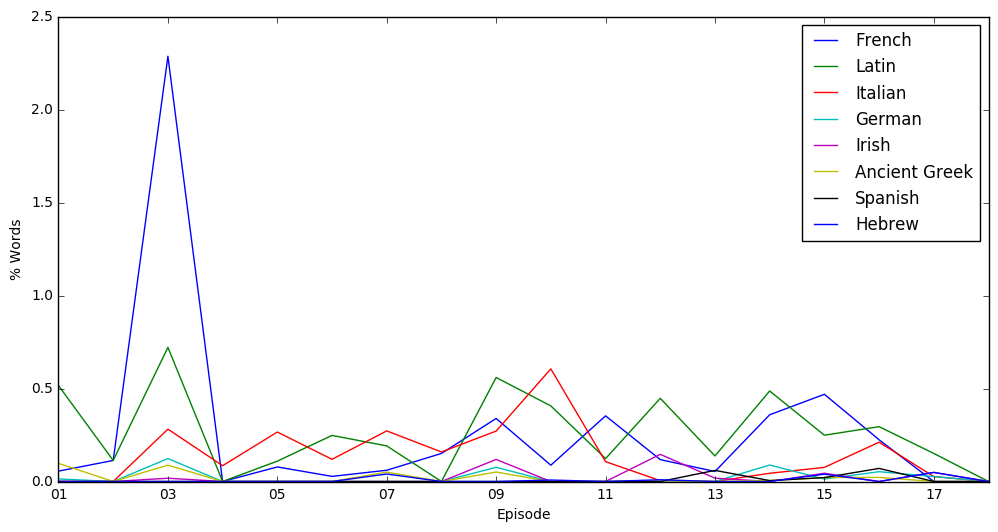

In [9]:
df.index.name = 'Episode'
ax = df[topLangs.index].fillna(0).plot()
ax.set_ylabel('% Words')